# Image Foler 

* dataset

# Scheduler

* To change the learning rate

# Transfer Learning

* Pretrained ResNet-18 CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [12]:
# import data
data_dir = "datasets/hymenoptera_data" # personal dataset
sets = ["train", "val"]
image_datasets = {
    x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)

['ants', 'bees']


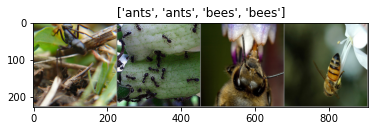

In [13]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Transfer Learning, Fine Tuning

## Finetune the whole network

In [19]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # # of features in last layer
print(f"num_ftrs: {num_ftrs}")

model.fc = nn.Linear(num_ftrs, 2) # change last layer to 2 classes (because our dataset has 2 classes : ants and bees)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # every 7 epochs, lr is multiplied by 0.1

num_ftrs: 512


In [20]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6374 Acc: 0.6352
val Loss: 0.4262 Acc: 0.8693

Epoch 1/19
----------
train Loss: 0.5397 Acc: 0.7418
val Loss: 0.3215 Acc: 0.9150

Epoch 2/19
----------
train Loss: 0.4569 Acc: 0.7910
val Loss: 0.2710 Acc: 0.9150

Epoch 3/19
----------
train Loss: 0.4171 Acc: 0.8074
val Loss: 0.2362 Acc: 0.9346

Epoch 4/19
----------
train Loss: 0.3889 Acc: 0.8402
val Loss: 0.2213 Acc: 0.9281

Epoch 5/19
----------
train Loss: 0.4068 Acc: 0.8033
val Loss: 0.1990 Acc: 0.9346

Epoch 6/19
----------
train Loss: 0.3440 Acc: 0.8648
val Loss: 0.1845 Acc: 0.9346

Epoch 7/19
----------
train Loss: 0.4054 Acc: 0.8115
val Loss: 0.1899 Acc: 0.9346

Epoch 8/19
----------
train Loss: 0.3139 Acc: 0.8811
val Loss: 0.1823 Acc: 0.9281

Epoch 9/19
----------
train Loss: 0.3727 Acc: 0.7910
val Loss: 0.1817 Acc: 0.9346

Epoch 10/19
----------
train Loss: 0.3238 Acc: 0.8525
val Loss: 0.1923 Acc: 0.9281

Epoch 11/19
----------
train Loss: 0.3232 Acc: 0.8852
val Loss: 0.1838 Acc: 0.9412

Ep

## Finetune only the last layer

In [21]:
# freeze all layers except last layer (more faster than training all layers)
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False # freeze all layers
num_ftrs = model.fc.in_features # # of features in last layer

model.fc = nn.Linear(num_ftrs, 2) # change last layer to 2 classes (because our dataset has 2 classes : ants and bees)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # every 7 epochs, lr is multiplied by 0.1

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.7320 Acc: 0.4754
val Loss: 0.5864 Acc: 0.7320

Epoch 1/19
----------
train Loss: 0.6217 Acc: 0.6352
val Loss: 0.4600 Acc: 0.8562

Epoch 2/19
----------
train Loss: 0.5498 Acc: 0.7541
val Loss: 0.3956 Acc: 0.8627

Epoch 3/19
----------
train Loss: 0.4693 Acc: 0.8279
val Loss: 0.3316 Acc: 0.8954

Epoch 4/19
----------
train Loss: 0.4910 Acc: 0.7746
val Loss: 0.2964 Acc: 0.9085

Epoch 5/19
----------
train Loss: 0.4692 Acc: 0.7500
val Loss: 0.2921 Acc: 0.9085

Epoch 6/19
----------
train Loss: 0.4167 Acc: 0.8320
val Loss: 0.2589 Acc: 0.9150

Epoch 7/19
----------
train Loss: 0.4099 Acc: 0.8197
val Loss: 0.2588 Acc: 0.9150

Epoch 8/19
----------
train Loss: 0.4232 Acc: 0.8115
val Loss: 0.2553 Acc: 0.9085

Epoch 9/19
----------
train Loss: 0.4274 Acc: 0.8197
val Loss: 0.2601 Acc: 0.9150

Epoch 10/19
----------
train Loss: 0.4577 Acc: 0.7869
val Loss: 0.2573 Acc: 0.9216

Epoch 11/19
----------
train Loss: 0.3831 Acc: 0.8525
val Loss: 0.2607 Acc: 0.9085

Ep